# Q-Learning Almacén

Vamos a utilizar Q-Learning para resolver un ejercicio de aprendizaje por refuerzo desde 0. Incluyendo la definición del entorno y la implementación del algoritmo.

## Entorno

Vamos a modelar un laberinto representado por una matriz de 0s y 1s. Los 0s representan las casillas por las que se puede pasar y los 1s las casillas que están bloqueadas. El objetivo es llegar desde la casilla de inicio (esquina superior izquierda, rojo) hasta la casilla de llegada (esquina inferior derecha, verde). El agente puede moverse en las 4 direcciones (arriba, abajo, izquierda y derecha) pero no puede salirse del laberinto ni pasar por las casillas bloqueadas:

<br>
<img src = "images/laberinto1.png" width = 40%>

### Acciones

El agente se movera por el laberinto, pudiendo desplazarse hacia arriba, abajo, izquierda o derecha. Cada acción se representa como una tupla de 2 elementos, donde el primer elemento es el desplazamiento en el eje x y el segundo en el eje y:
1. Izquierda: (0, -1)
2. Derecha: (0, 1)
3. Arriba: (0, -1)
4. Abajo: (0, 1)

### Estado

El estado se representa como una tupla de 2 elementos, donde el primer elemento es la posición en el eje x y el segundo en el eje y. 

El estado inicial es siempre (0, 8) y el estado final es (10, 1).

### Recomenpensas

En cada movimiento, el agente recibe una recompensa de -1, para presionarle a resolver el problema lo más rápido posible.

Si llega a la casilla de salida, recibe una recompensa de 100 y el episodio termina.

Si se sale del laberinto o se mueve hacia una pared, recibe una recompensa de -10 y el episodio termina.

## Definición del entorno

Considerando lo anterior, vamos a definir el entorno como una clase de Python, replicando la estructura de los entornos de OpenAI Gym.

In [243]:
import numpy as np

class Labyrinth:
    def __init__(self, labyrinth):
        self.labyrinth = labyrinth
        self.actions = ['left', 'right', 'up', 'down']
        self.state = (1,0)
        self.init_state = (1,0)
        self.goal_state = (8,10)
        self.num_rows = len(labyrinth)
        self.num_cols = len(labyrinth[0])
        


    def reset(self):
        self.state = self.init_state
        return self.state

    def random_action(self):
        return np.random.choice(self.actions)

    def q_table(self):
        return np.zeros((len(self.labyrinth), len(self.labyrinth[0]), len(self.actions)))

    def get_reward(self, state):
        if state == self.goal_state:
            return 100, True
        else:
            return -1, False
        
    def get_action_displacemen(self, action):
        if action == 'left':
            return (0, -1)
        elif action == 'right':
            return (0, 1)
        elif action == 'up':
            return (-1, 0)
        elif action == 'down':
            return (1, 0)
        
    def hit_wall(self, state):
        if state[0] < 0 or state[0] >= len(self.labyrinth) or state[1] < 0 or state[1] >= len(self.labyrinth[0]):
            return True
        elif self.labyrinth[state[0]][state[1]] == 1:
            return True
        else:
            return False
        
    def step(self, action):
        displacement = self.get_action_displacemen(action)
        new_state = (self.state[0] + displacement[0], self.state[1] + displacement[1])

        if self.hit_wall(new_state):
            return self.state, -10, True
        else:
            reward, done = self.get_reward(new_state)
            self.state = new_state
            return new_state, reward, done

## Definición del agente

Aunque no es estrictamente necesario, vamos a definir el agente como una clase de Python.

In [244]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.q_table = env.q_table()
        self.alpha = 0.1    # learning rate
        self.gamma = 0.6    # discount factor

    def pick_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return self.env.random_action()
        else:
            return self.env.actions[np.argmax(self.q_table[state[0]][state[1]])]
        
    def update_q_table(self, state, action, reward, new_state):
        action_idx = self.env.actions.index(action)
        self.q_table[state[0]][state[1]][action_idx] = (
            (1 - self.alpha) * self.q_table[state[0]][state[1]][action_idx] + 
            self.alpha * (reward + self.gamma * np.max(self.q_table[new_state[0]][new_state[1]]))
        )

## Resolución del problema

In [245]:
# Define the labyrinth
labyrinth = [
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
[1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
]

In [246]:
# Create the environment
env = Labyrinth(labyrinth)

# Create the agent
agent = Agent(env)

epsilon = 0.1  # exploration rate
num_episodes = 1000
max_steps = 100

episode_rewards = []

for episode in range(num_episodes):
    current_state = env.reset()
    done = False
    step = 0
    episode_reward = 0

    while not done and step < max_steps:
        action = agent.pick_action(current_state, epsilon)

        new_state, reward, done = env.step(action)

        agent.update_q_table(current_state, action, reward, new_state)

        step += 1

        #print(f"{episode} - {step}.   State: {current_state} -> {new_state}. \t [{action}, {reward}, {done}]")

        current_state = new_state
        episode_reward += reward

    episode_rewards.append(episode_reward)
    if episode > 0 and (episode+1) % (num_episodes/10) == 0:
        # average last 100 episodes
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {episode} - Reward: {avg_reward}")
    #print()

Episode 99 - Reward: -19.32
Episode 199 - Reward: -25.73
Episode 299 - Reward: -25.12
Episode 399 - Reward: -27.59


Episode 499 - Reward: -22.77
Episode 599 - Reward: -15.43
Episode 699 - Reward: -4.17
Episode 799 - Reward: -1.0
Episode 899 - Reward: 6.28
Episode 999 - Reward: 13.37


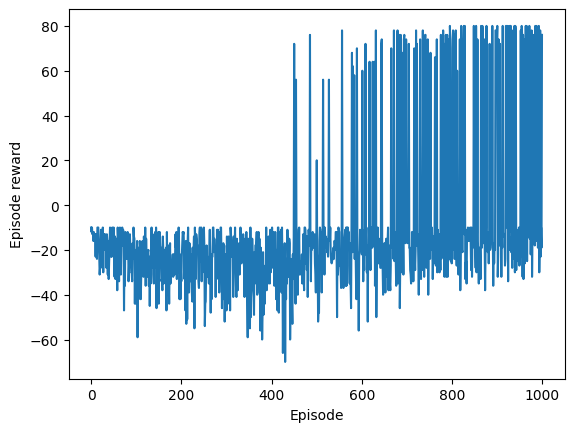

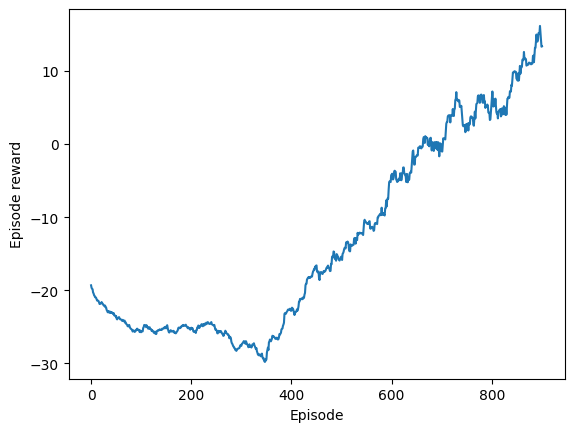

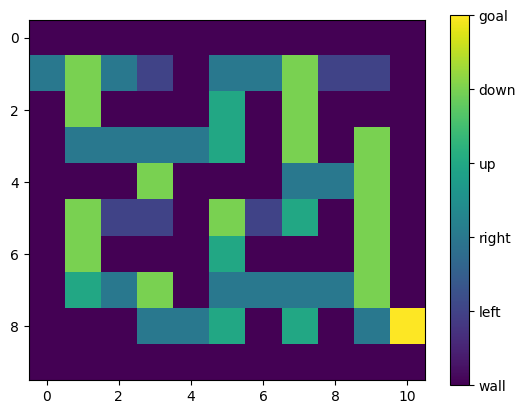

In [247]:
# Plot the episode rewards
import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.show()

# moving average of the episode rewards
plt.plot(np.convolve(episode_rewards, np.ones((100,))/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.show()

# Plot the learned policy
policy = np.zeros((len(labyrinth), len(labyrinth[0])))
for i in range(len(labyrinth)):
    for j in range(len(labyrinth[0])):
        if labyrinth[i][j] == 1:
            policy[i][j] = 0
        else:
            policy[i][j] = np.argmax(agent.q_table[i][j]) + 1
policy[env.goal_state[0]][env.goal_state[1]] = 5

plt.imshow(policy)
cb = plt.colorbar(ticks=[0, 1, 2, 3, 4, 5])
cb.ax.set_yticklabels(['wall', 'left', 'right', 'up', 'down', 'goal'])
plt.show()

# Deep Q-Learning

Resolvemos el mismo problema pero utilizando Deep Q-Learning.

La definición del entorno es la misma, pero el agente ahora es una red neuronal.

In [248]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class Agent:
    def __init__(self, env):
        self.env = env
        self.state_shape = (env.num_rows, env.num_cols)  # State shape
        self.num_actions = len(env.actions)  # Number of actions
        
        self.q_table = env.q_table()
        self.alpha = 0.1    # learning rate
        self.gamma = 0.6    # discount factor

        self.model = self.build_model()  # Q-value approximation model
        self.target_model = self.build_model()  # target Q-value approximation model
        self.target_model.set_weights(self.model.get_weights())

        self.epsilon = 0.5  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99

        self.batch_size = 128
        self.memory = []                 # memory for experience replay
        self.max_memory_length = 1000    # maximum size of memory

    def build_model(self):
        model = keras.Sequential([
            keras.layers.Flatten(input_shape=self.state_shape),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(self.num_actions)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.alpha)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    def state_matrix_from_state(self, state):
        state_matrix = np.zeros(self.state_shape)
        state_matrix[state[0]][state[1]] = 1
        return state_matrix
    
    def pick_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.random_action()
        state_matrix = self.state_matrix_from_state(state)
        q_values = self.model.predict(np.array([state_matrix]), verbose=0)[0]
        return self.env.actions[np.argmax(q_values)]
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.max_memory_length:
            del self.memory[0]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # get a list of self.batch_size random indices from the memory
        batch_idx = np.random.choice(len(self.memory), self.batch_size, replace=False)
        batch = [self.memory[i] for i in batch_idx]

        states = []
        targets = []

        for state, action, reward, next_state, done in batch:
            state_matrix = self.state_matrix_from_state(state)
            next_state_matrix = self.state_matrix_from_state(next_state)
            action_idx = self.env.actions.index(action)

            target = self.model.predict(np.array([state_matrix]), verbose=0)[0]
            if done:
                #print(done, target, action, reward)
                target[action_idx] = reward
            else:
                #pred = self.target_model.predict(np.array([next_state_matrix]), verbose=0)
                #print(done, pred)
                target[action_idx] = reward + self.gamma * np.max(self.target_model.predict(np.array([next_state_matrix]), verbose=0)[0])

            states.append(state_matrix)
            targets.append(target)

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * 0.1 + target_weights[i] * 0.9
        self.target_model.set_weights(target_weights)

In [249]:
# Create the environment
env = Labyrinth(labyrinth)

# Create the agent
agent = Agent(env)

num_episodes = 10000
max_steps = 200

train_count = 0
train_every = 64

episode_rewards = []
episode_final_steps = []

for episode in range(num_episodes):
    current_state = env.reset()
    done = False
    step = 0
    episode_reward = 0

    while not done and step < max_steps:
        action = agent.pick_action(current_state)

        new_state, reward, done = env.step(action)

        agent.remember(current_state, action, reward, new_state, done)

        if train_count > 0 and train_count % train_every == 0:
            agent.replay()
            agent.target_train()
        
        #print(f"{episode} - {step}.   State: {current_state} -> {new_state}. \t [{action}, {reward}, {done}]")

        train_count += 1
        step += 1
        current_state = new_state
        episode_reward += reward

    episode_rewards.append(episode_reward)
    episode_final_steps.append(step)
    if episode > 0 and (episode+1) % (num_episodes/100) == 0:
        # average last 100 episodes
        avg_reward = np.mean(episode_rewards[-100:])
        avg_step = np.mean(episode_final_steps[-100:])
        print(f"Episode {episode} - Reward: {avg_reward} - Final step: {avg_step} - CurrentEpsilon: {agent.epsilon}")
    #print()

Episode 99 - Reward: -10.2 - Final step: 1.2 - CurrentEpsilon: 0.5


KeyboardInterrupt: 

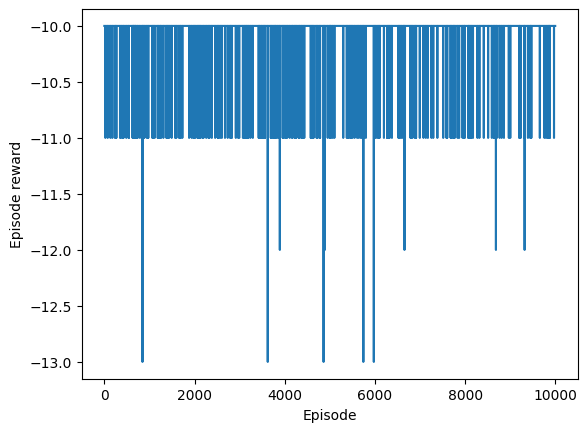

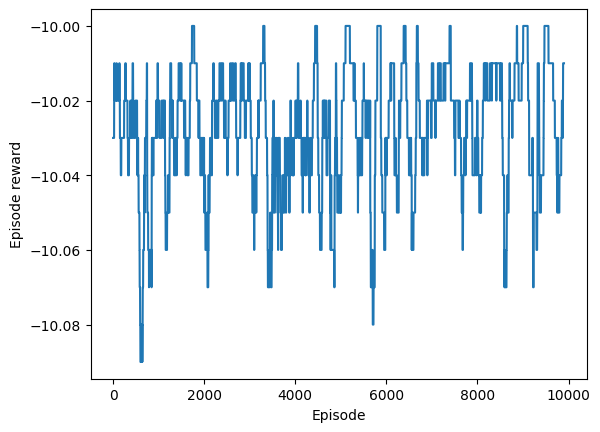

1/1 [==============================] - 0s 15ms/step


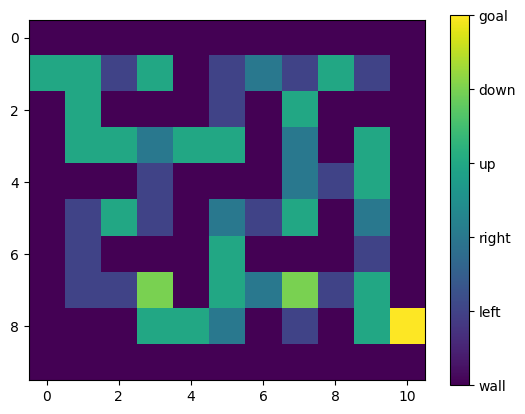

In [ ]:
# Plot the episode rewards
import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.show()

# moving average of the episode rewards
plt.plot(np.convolve(episode_rewards, np.ones((100,))/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.show()

# Plot the learned policy
policy = np.zeros((len(labyrinth), len(labyrinth[0])))
for i in range(len(labyrinth)):
    for j in range(len(labyrinth[0])):
        if labyrinth[i][j] == 1:
            policy[i][j] = 0
        else:
            action = agent.pick_action((i,j), 0)
            policy[i][j] = env.actions.index(action) + 1
policy[env.goal_state[0]][env.goal_state[1]] = 5

plt.imshow(policy)
cb = plt.colorbar(ticks=[0, 1, 2, 3, 4, 5])
cb.ax.set_yticklabels(['wall', 'left', 'right', 'up', 'down', 'goal'])
plt.show()